**Porcentaje de población de la Ciudad de México que se siente inseguro en el transporte público**

In [21]:
rm(list=ls()) #Limpiar el entorno de trabajo
#Librerías
#if (require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,
               srvyr, 
               ggplot2, 
               purrr, 
               dplyr)

In [22]:
#Función para leer los datos de la ENVIPE
leer_envipe_vic <- function(anios) {

  anios <- as.integer(anios)[anios %in% 2016:2024]
  

  data_list <- list()

  for (anio in anios) {
    url <- paste0("https://www.inegi.org.mx/contenidos/programas/envipe/",
                  anio,
                 "/microdatos/bd_envipe",
                 ifelse(anio < 2020, anio, paste0("_", anio)),
                 "_dbf.zip")

    temp_zip <- tempfile(fileext = ".zip")
    temp_dir <- tempdir()
    options(timeout = 1000)

    result <- download.file(url, temp_zip, mode = "wb", quiet = TRUE)
              unzip(temp_zip, exdir = temp_dir)

    nombre <- list.files(temp_dir, pattern = "TPer_Vic1.dbf", 
                             full.names = TRUE, recursive = TRUE)
                             
    datos <- foreign::read.dbf(nombre)|>
                  mutate(ENT = substr(ID_VIV, 1, 2),
                        #Crear variable de interes para inseguridad en transporte público
                        inse_t_publico = case_when(AP4_4_09 == "1" ~ "Se siente seguro", 
                                      AP4_4_09 == "2" ~ "Se siente inseguro", 
                                      TRUE ~ "No responde"),
                        FAC_ELE = as.numeric(FAC_ELE))|>
                   #Filtrar para la Ciudad de México
                   filter(ENT == "09",
                          AP4_4_09!=3)


    #Poner los datos en una lista
    data_list[[as.character(anio)]] <- datos

    # Limpiar archivos temporales
    unlink(temp_zip)
    unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  }

  return(data_list)
}

In [23]:
# Función para definir diseño muestral
diseño_muestral_l <- function(lista_datos) {
  
  lista_dm <- list()

  for (anio in names(lista_datos)) {
    datos <- lista_datos[[anio]]

    diseño <- datos|>
      as_survey_design(strata = EST_DIS,
                       weights = FAC_ELE,
                       ids = UPM_DIS,
                       nest = TRUE)

    lista_dm[[anio]] <- diseño 
  }

  return(lista_dm)
}

In [34]:
#Función para obtener los porcentajes y totales con coeficiente de variación
resultados_inseguridad <- function(lista_c_dm) {

  resultados_l <- list()

  for (anio in names(lista_c_dm)) {
    datos <- lista_c_dm[[anio]]
  
  resultados <- datos|>
                group_by(inse_t_publico) |>
                summarise(tot_p_inseg_tp = survey_total(vartype = "cv"),
                porcentaje = round(survey_prop(vartype = "cv") * 100,1))|>
    filter(inse_t_publico == "Se siente inseguro")|>
    select(inse_t_publico, porcentaje, porcentaje_cv)|>
    mutate(ano = as.integer(anio),
           tipo = "Observado")

    resultados_l[[anio]] <- resultados 
  }
  return(resultados_l)
}

In [25]:
#Función para generar tendencias
tendencias <- function(datos, anio_inicio, anio_base, proyecciones) {
  
  pct_inicio <- datos|> 
    dplyr::filter(ano == anio_inicio)|> 
    dplyr::pull(porcentaje)
  
  pct_base <- datos|> 
    dplyr::filter(ano == anio_base)|> 
    dplyr::pull(porcentaje)

  #TCMA
  tcma <- ((pct_base / pct_inicio)^(1 / (anio_base - anio_inicio))) - 1

  # Definir condicionantes para cada escenario
  escenarios <- c(Inercial = 1/4,
                  Deseable = 1/2,
                  Transformador = 3/4)

  #Proyección para cada escenario
  tendencias <- purrr::map_dfr(names(escenarios),
               function(tipo) {
               data.frame( ano = proyecciones,
                           porcentaje = round(pct_base * (1 + escenarios[[tipo]] * tcma) ^ (proyecciones - anio_base), 2),
                           tipo = tipo)
                           }
  )

  #Agregar a los datos originales
  datos_proyectados <- datos|>
                       select(porcentaje, ano, tipo)|>  
                       bind_rows(tendencias)|>
    select(ano, porcentaje, tipo)

  return(datos_proyectados)
}

In [26]:
# Función para generar líneas de tendencia (para los gráficos)
lineas_tendencia <- function(data, ano_base, ano_meta) {
  tipos <- c("Inercial", "Deseable", "Transformador")
  
  lineas <- map_dfr(tipos, function(tipo) {
    porcentaje_base <- data$porcentaje[data$ano == ano_base & data$tipo == "Observado"]
    porcentaje_meta <- data$porcentaje[data$ano == ano_meta & data$tipo == tipo]
    
    data.frame(ano = c(ano_base, ano_meta),
               porcentaje = c(porcentaje_base, porcentaje_meta),
               tipo = tipo)
  })
  
  return(lineas)
}


In [27]:
#Leer datos de la ENVIPE
lista_envipe_vic <- leer_envipe_vic(2016:2024)

In [28]:
# Crear lista de diseño muestral para cada serie
lista_dm <- diseño_muestral_l(lista_envipe_vic)

In [35]:
# Aplica la función a la lista de diseños muestrales
resultados_envipe <- resultados_inseguridad(lista_dm)
#Convertir la lista a un data frame
inseguridad_transporte_publico <- bind_rows(resultados_envipe, .id = "anio")
#Mostrar los resultados
inseguridad_transporte_publico

anio,inse_t_publico,porcentaje,porcentaje_cv,ano,tipo
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
2016,Se siente inseguro,87.2,1.1,2016,Observado
2017,Se siente inseguro,90.1,0.6,2017,Observado
2018,Se siente inseguro,90.7,0.5,2018,Observado
2019,Se siente inseguro,91.5,0.5,2019,Observado
2020,Se siente inseguro,87.9,0.6,2020,Observado
2021,Se siente inseguro,88.3,0.6,2021,Observado
2022,Se siente inseguro,86.1,0.7,2022,Observado
2023,Se siente inseguro,80.7,0.8,2023,Observado
2024,Se siente inseguro,77.8,0.9,2024,Observado


In [30]:
#Escenarios inercial, deseable y tranformador
inseguridad_transporte_tendencias <- tendencias(
  datos = inseguridad_transporte_publico,
  anio_inicio = 2023,
  anio_base = 2024,
  proyecciones = c(2030, 2035, 2045)
)

inseguridad_transporte_tendencias

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,87.17603,Observado
2017,90.06787,Observado
2018,90.72703,Observado
2019,91.45405,Observado
2020,87.94672,Observado
2021,88.25421,Observado
2022,86.08960,Observado
2023,80.67437,Observado
2024,77.76181,Observado


In [31]:
#Lineas de tendencia para los gráficos
lineas <- lineas_tendencia(inseguridad_transporte_tendencias, 
                           ano_base = 2024, 
                           ano_meta = 2030)

lineas

ano,porcentaje,tipo
<dbl>,<dbl>,<chr>
2024,77.76181,Inercial
2030,73.64000,Inercial
2024,77.76181,Deseable
2030,69.71000,Deseable
2024,77.76181,Transformador
2030,65.95000,Transformador


In [32]:
#Paleta de colores y tipos de línea
paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")


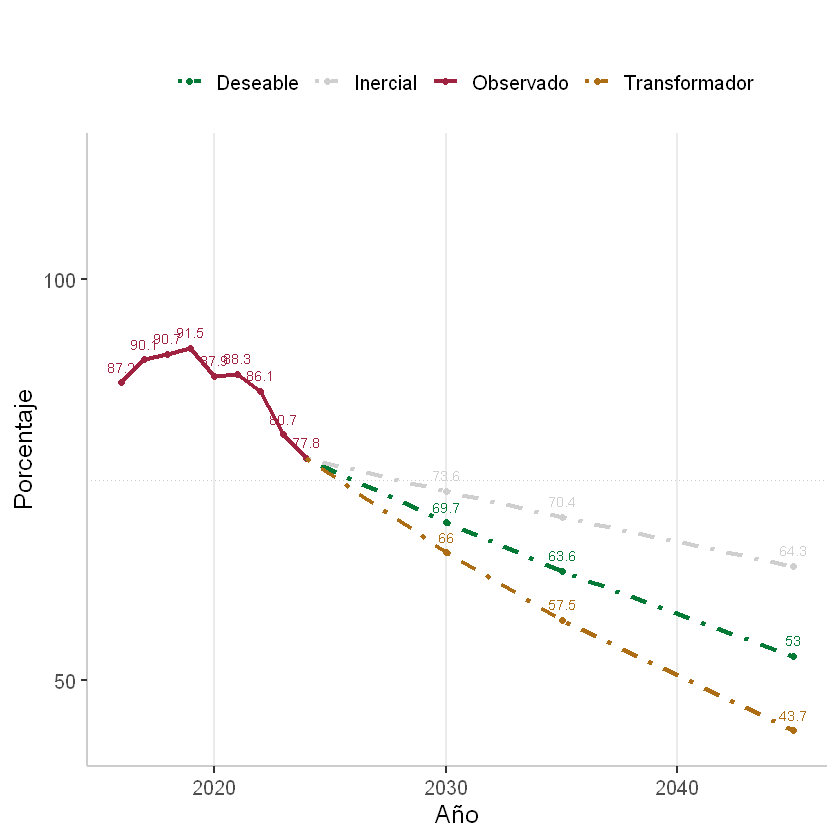

In [33]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(inseguridad_transporte_tendencias, aes(x = ano, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = ano, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = round(porcentaje, 1)),
            position = position_nudge(y = 2),
            size = 3, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(inseguridad_transporte_tendencias$porcentaje, na.rm = TRUE) +100, by = 50),
                     labels = function(x) paste0(x, ""),
                     expand = expansion(mult = c(0.09,0.5))) +
  labs(title = "",
       x = "Año",
       y = "Porcentaje",
       color = "",
       linetype = "") +
  theme_bw(base_size = 15) +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 100))

#ggsave("inseguridad_transporte_tendencias.png", width = 8, height = 5, dpi = 300)